#### Imports

In [1]:
import os
from PIL import Image
import pandas as pd
import torch
from torch import optim
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

### Device Setting

In [2]:
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"GPU is available with {num_gpus} device(s).")

    # Get the name of the current GPU
    current_gpu = torch.cuda.get_device_name(0)  # Assuming the first GPU is used
    print(f"Current GPU: {current_gpu}")
else:
    print("GPU is not available. Using CPU.")

GPU is not available. Using CPU.


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the first available GPU
else:
    device = torch.device("cpu")  # If no GPU is available, use CPU

#### Dataset class

In [4]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_folder, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_folder = img_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_folder, f"{self.df['unique_id'].iloc[idx]}.jpg")
        image = Image.open(img_name)  # stack overflow .convert("RGB")

        target = torch.tensor(self.df['loss_percentage'].iloc[idx], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, target

In [26]:
transform = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [27]:
custom_dataset = CustomDataset(csv_file='filtered_data.csv', img_folder='SolarPanelSoilingImageDataset\Solar_Panel_Soiling_Image_dataset\Pytorch_data/', transform=transform)


In [28]:
dataloader = DataLoader(custom_dataset, batch_size=32, shuffle=False)


### Visualize the loaded data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

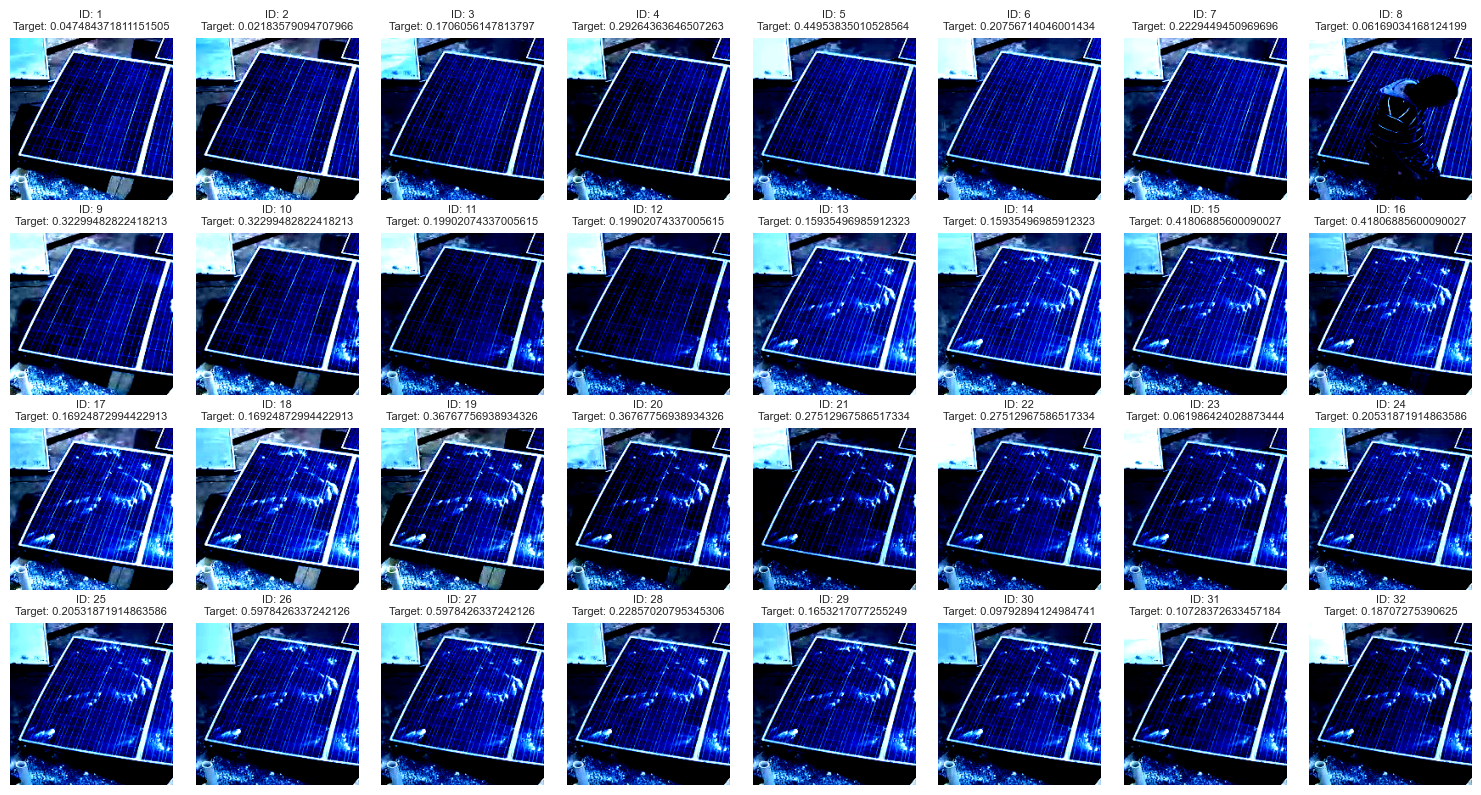

In [29]:
images, targets = next(iter(dataloader))

# Convert images to numpy arrays
np_images = images.numpy()

# Define the size of the grid
num_rows = 4
num_cols = 8

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Visualize each image along with its target and ID from the folder
for i in range(num_rows * num_cols):
    image = np.transpose(np_images[i], (1, 2, 0))  # Change the order of dimensions for displaying with matplotlib
    target = targets[i].item()
    image_id = custom_dataset.df['unique_id'].iloc[i]

    axes[i].imshow(image)
    axes[i].set_title(f'ID: {image_id}\nTarget: {target}', fontsize=8)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### NN Architecture

In [32]:
class RegressionCNN(nn.Module):
    def __init__(self):
        super(RegressionCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 48 * 48, 512)
        self.fc2 = nn.Linear(512, 1)  # Output dimension is 1 for regression

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the input for the fully connected layers
        x = x.view(-1, 128 * 48 * 48)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [33]:
def train_regression(model, train_loader, num_epochs=10, learning_rate=0.001):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    mse_losses = []
    r2_scores = []

    for epoch in range(num_epochs):
        model.train()
        running_mse = 0.0
        total_samples = 0
        predictions = []
        targets = []

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_mse += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            predictions.extend(outputs.cpu().detach().numpy())
            targets.extend(labels.cpu().detach().numpy())

            # Print progress every, for example, 10 batches
            if batch_idx % 10 == 0:
                percent_complete = 100. * batch_idx / len(train_loader)
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, {percent_complete:.2f}% Complete")

        epoch_mse = running_mse / total_samples
        mse_losses.append(epoch_mse)

        r2 = r2_score(targets, predictions)
        r2_scores.append(r2)

        print(f"Epoch {epoch+1}/{num_epochs}, MSE Loss: {epoch_mse}, R^2: {r2}")

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), mse_losses, label='MSE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), r2_scores, label='R^2 Score', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('R^2 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

#### Train Test Split

In [34]:
train_dataset, test_dataset = train_test_split(custom_dataset, test_size=0.2 , shuffle=False)

# Create DataLoader instances for training and testing sets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [35]:
model = RegressionCNN()


In [36]:
train_regression(model, train_dataloader, num_epochs=10, learning_rate=0.001)

C:\Python\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Batch 0/634, 0.00% Complete
Epoch 1/10, Batch 10/634, 1.58% Complete
Epoch 1/10, Batch 20/634, 3.15% Complete
Epoch 1/10, Batch 30/634, 4.73% Complete
Epoch 1/10, Batch 40/634, 6.31% Complete
Epoch 1/10, Batch 50/634, 7.89% Complete
Epoch 1/10, Batch 60/634, 9.46% Complete
Epoch 1/10, Batch 70/634, 11.04% Complete
Epoch 1/10, Batch 80/634, 12.62% Complete
Epoch 1/10, Batch 90/634, 14.20% Complete
Epoch 1/10, Batch 100/634, 15.77% Complete
Epoch 1/10, Batch 110/634, 17.35% Complete
Epoch 1/10, Batch 120/634, 18.93% Complete
Epoch 1/10, Batch 130/634, 20.50% Complete
Epoch 1/10, Batch 140/634, 22.08% Complete
Epoch 1/10, Batch 150/634, 23.66% Complete
Epoch 1/10, Batch 160/634, 25.24% Complete
Epoch 1/10, Batch 170/634, 26.81% Complete
Epoch 1/10, Batch 180/634, 28.39% Complete
Epoch 1/10, Batch 190/634, 29.97% Complete
Epoch 1/10, Batch 200/634, 31.55% Complete
Epoch 1/10, Batch 210/634, 33.12% Complete
Epoch 1/10, Batch 220/634, 34.70% Complete
Epoch 1/10, Batch 230/634, 36

C:\Python\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ValueError: Found input variables with inconsistent numbers of samples: [20284, 5071]